# آساطير الغد- legends of tomorrow
`8 years `

In [ ]:
!pip install eyed3

In [ ]:
!pip install pyAudioAnalysis

In [ ]:
!pip install deepface

In [ ]:
!pip install ultralytics

**1- Jumping with ball**

In [11]:
import cv2
import numpy as np
from ultralytics import YOLO

# Load YOLO models
pose_model = YOLO('yolov8n-pose.pt')         # For keypoints
ball_model = YOLO('yolov8n.pt')              # For detecting the ball

# ----- Skill 1: Jumping with Ball -----
def detect_ball_knee_contacts(video_path, frame_skip=2, distance_thresh=40, angle_thresh=60):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    touch_count = 0
    successful_touches = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            frame_idx += 1
            continue

        ball_results = ball_model(frame)[0]
        ball_pos = None
        for box, cls in zip(ball_results.boxes.xyxy, ball_results.boxes.cls):
            if int(cls) == 32:
                x1, y1, x2, y2 = map(int, box)
                ball_pos = ((x1 + x2) // 2, (y1 + y2) // 2)
                break

        pose_results = pose_model(frame)[0]
        if pose_results.keypoints is not None and pose_results.keypoints.xy.shape[0] > 0:
            keypoints = pose_results.keypoints.xy.cpu().numpy()[0]
            if keypoints.shape[0] >= 17:
                hip = keypoints[11]
                knee = keypoints[13]
                ankle = keypoints[15]

                def angle(a, b, c):
                    a, b, c = np.array(a), np.array(b), np.array(c)
                    ang = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
                    return np.abs(np.degrees(ang)) % 180

                knee_angle = angle(hip, knee, ankle)

                if ball_pos:
                    dist = np.linalg.norm(np.array(ball_pos) - np.array(knee))
                    if dist < distance_thresh and knee_angle < angle_thresh:
                        touch_count += 1
                        successful_touches.append({"frame": frame_idx, "distance": round(dist, 1), "angle": round(knee_angle, 1)})

        frame_idx += 1

    cap.release()
    score = min(5, touch_count)
    return score

In [26]:
def run_jump_evaluation_path(video_path):
    """
    تُشغّل تقييم القفز باستخدام مسار الفيديو المحدد.

    المعامل:
    - video_path: مسار الفيديو (مثل 'videos/jump.mp4')
    """
    print("🏃‍♂️ جاري تقييم القفز باستخدام الكرة...")
    score = detect_ball_knee_contacts(video_path)
    print(f"✅ درجة القفز بالكرة: {score}/5")
    return score
run_jump_evaluation_path("/content/9502550-sd_506_960_24fps.mp4")

🏃‍♂️ جاري تقييم القفز باستخدام الكرة...

0: 640x352 1 person, 1 sports ball, 175.0ms
Speed: 3.4ms preprocess, 175.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 161.1ms
Speed: 4.0ms preprocess, 161.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 155.4ms
Speed: 4.0ms preprocess, 155.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 184.7ms
Speed: 4.8ms preprocess, 184.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 178.7ms
Speed: 4.9ms preprocess, 178.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 156.9ms
Speed: 3.9ms preprocess, 156.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 147.7ms
Speed: 3.6ms preprocess, 147.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 

0

**3-Running with Ball**

In [28]:
# ----- Skill 2: Running with Ball -----
def evaluate_running_with_ball(video_path, frame_skip=2, min_ball_distance=30):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    distances = []
    prev_mid_hip = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            frame_idx += 1
            continue

        ball_results = ball_model(frame)[0]
        ball_pos = None
        for box, cls in zip(ball_results.boxes.xyxy, ball_results.boxes.cls):
            if int(cls) == 32:
                x1, y1, x2, y2 = map(int, box)
                ball_pos = ((x1 + x2) // 2, (y1 + y2) // 2)
                break

        pose_results = pose_model(frame)[0]
        if pose_results.keypoints is not None and pose_results.keypoints.xy.shape[0] > 0:
            keypoints = pose_results.keypoints.xy.cpu().numpy()[0]
            if keypoints.shape[0] >= 17:
                mid_hip = (keypoints[11] + keypoints[12]) / 2

                if ball_pos is not None:
                    ball_distance = np.linalg.norm(np.array(mid_hip) - np.array(ball_pos))
                    if ball_distance < min_ball_distance:
                        if prev_mid_hip is not None:
                            dx = mid_hip[0] - prev_mid_hip[0]
                            dy = mid_hip[1] - prev_mid_hip[1]
                            dist = np.sqrt(dx**2 + dy**2)
                            distances.append(dist)
                        prev_mid_hip = mid_hip

        frame_idx += 1

    cap.release()
    avg_speed = np.mean(distances) if distances else 0
    score = min(5, int(avg_speed * 10))
    return score

# ----- Run Running Evaluation -----
def run_running_evaluation_path(video_path):
    print("🏃‍♂️ جاري تقييم الجري بالكرة...")
    score = evaluate_running_with_ball(video_path)
    print(f"✅ درجة الجري بالكرة: {score}/5")
    return score
run_running_evaluation_path("/content/9502550-sd_506_960_24fps.mp4")

🏃‍♂️ جاري تقييم الجري بالكرة...

0: 640x352 1 person, 1 sports ball, 168.8ms
Speed: 5.3ms preprocess, 168.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 167.0ms
Speed: 4.4ms preprocess, 167.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 159.2ms
Speed: 4.1ms preprocess, 159.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 166.7ms
Speed: 3.8ms preprocess, 166.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 153.6ms
Speed: 3.4ms preprocess, 153.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 181.4ms
Speed: 3.5ms preprocess, 181.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 176.0ms
Speed: 4.1ms preprocess, 176.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 

0

# 3-Passing

In [30]:
# ----- Skill 3: Passing -----
def evaluate_passing(video_path, frame_skip=2, ball_distance_thresh=100):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    pass_attempts = 0
    successful_passes = 0
    previous_ball_pos = None
    previous_mid_ankle = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            frame_idx += 1
            continue

        ball_results = ball_model(frame)[0]
        ball_pos = None
        for box, cls in zip(ball_results.boxes.xyxy, ball_results.boxes.cls):
            if int(cls) == 32:
                x1, y1, x2, y2 = map(int, box)
                ball_pos = ((x1 + x2) // 2, (y1 + y2) // 2)
                break

        pose_results = pose_model(frame)[0]
        if pose_results.keypoints is not None and pose_results.keypoints.xy.shape[0] > 0:
            keypoints = pose_results.keypoints.xy.cpu().numpy()[0]
            if keypoints.shape[0] >= 17:
                left_ankle = keypoints[15]
                right_ankle = keypoints[16]
                mid_ankle = (left_ankle + right_ankle) / 2

                if previous_ball_pos and ball_pos:
                    ball_move = np.linalg.norm(np.array(ball_pos) - np.array(previous_ball_pos))
                    ankle_to_ball = np.linalg.norm(np.array(ball_pos) - mid_ankle)
                    if ball_move > 20 and ankle_to_ball > ball_distance_thresh:
                        pass_attempts += 1
                        if ball_move < 150:
                            successful_passes += 1

                previous_ball_pos = ball_pos
                previous_mid_ankle = mid_ankle

        frame_idx += 1

    cap.release()
    pass_score = min(5, successful_passes)
    return pass_score

# ----- Run Passing Evaluation -----
def run_passing_evaluation_path(video_path):
    print("⚽️ جاري تقييم التمرير...")
    score = evaluate_passing(video_path)
    print(f"✅ درجة التمرير: {score}/5")
    return score
run_passing_evaluation_path("/content/9502550-sd_506_960_24fps.mp4")

⚽️ جاري تقييم التمرير...

0: 640x352 1 person, 1 sports ball, 158.8ms
Speed: 4.7ms preprocess, 158.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 176.0ms
Speed: 3.3ms preprocess, 176.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 157.8ms
Speed: 3.9ms preprocess, 157.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 163.8ms
Speed: 3.6ms preprocess, 163.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 153.8ms
Speed: 3.9ms preprocess, 153.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 161.7ms
Speed: 3.8ms preprocess, 161.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 154.8ms
Speed: 4.3ms preprocess, 154.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 perso

5

# 4-Receiving

In [31]:

# ----- Skill 4: Receiving -----
def evaluate_receiving(video_path, frame_skip=2, ball_distance_thresh=100):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    successful_receives = 0
    previous_ball_pos = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            frame_idx += 1
            continue

        ball_results = ball_model(frame)[0]
        ball_pos = None
        for box, cls in zip(ball_results.boxes.xyxy, ball_results.boxes.cls):
            if int(cls) == 32:
                x1, y1, x2, y2 = map(int, box)
                ball_pos = ((x1 + x2) // 2, (y1 + y2) // 2)
                break

        pose_results = pose_model(frame)[0]
        if pose_results.keypoints is not None and pose_results.keypoints.xy.shape[0] > 0:
            keypoints = pose_results.keypoints.xy.cpu().numpy()[0]
            if keypoints.shape[0] >= 17:
                left_ankle = keypoints[15]
                right_ankle = keypoints[16]
                mid_ankle = (left_ankle + right_ankle) / 2

                if previous_ball_pos and ball_pos:
                    ankle_to_ball = np.linalg.norm(np.array(ball_pos) - mid_ankle)
                    if ankle_to_ball < ball_distance_thresh:
                        successful_receives += 1

                previous_ball_pos = ball_pos

        frame_idx += 1

    cap.release()
    receive_score = min(5, successful_receives)
    return receive_score

# ----- Run Receiving Evaluation -----
def run_receiving_evaluation_path(video_path):
    print("🎯 جاري تقييم الاستقبال...")
    score = evaluate_receiving(video_path)
    print(f"✅ درجة الاستقبال: {score}/5")
    return score
run_receiving_evaluation_path("/content/9502550-sd_506_960_24fps.mp4")

🎯 جاري تقييم الاستقبال...

0: 640x352 1 person, 1 sports ball, 158.5ms
Speed: 5.5ms preprocess, 158.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 158.0ms
Speed: 3.5ms preprocess, 158.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 156.6ms
Speed: 3.8ms preprocess, 156.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 175.1ms
Speed: 4.7ms preprocess, 175.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 156.6ms
Speed: 3.6ms preprocess, 156.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 165.8ms
Speed: 3.6ms preprocess, 165.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 166.6ms
Speed: 4.0ms preprocess, 166.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 pers

1

In [32]:
# ----- Skill 5: Zigzag Dribbling -----
def evaluate_zigzag_dribbling(video_path, frame_skip=2, direction_change_thresh=20):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    zigzag_changes = 0
    previous_mid_ankle = None
    last_direction = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            frame_idx += 1
            continue

        pose_results = pose_model(frame)[0]
        if pose_results.keypoints is not None and pose_results.keypoints.xy.shape[0] > 0:
            keypoints = pose_results.keypoints.xy.cpu().numpy()[0]
            if keypoints.shape[0] >= 17:
                left_ankle = keypoints[15]
                right_ankle = keypoints[16]
                mid_ankle = (left_ankle + right_ankle) / 2

                if previous_mid_ankle is not None:
                    dx = mid_ankle[0] - previous_mid_ankle[0]
                    if last_direction is not None and np.sign(dx) != np.sign(last_direction) and abs(dx) > direction_change_thresh:
                        zigzag_changes += 1
                    last_direction = dx

                previous_mid_ankle = mid_ankle

        frame_idx += 1

    cap.release()
    zigzag_score = min(5, zigzag_changes // 2)
    return zigzag_score

# ----- Run Zigzag Dribbling Evaluation -----
def run_zigzag_evaluation_path(video_path):
    print("🌀 جاري تقييم المراوغة الزجزاجية...")
    score = evaluate_zigzag_dribbling(video_path)
    print(f"✅ درجة المراوغة الزجزاجية: {score}/5")
    return score

In [33]:
# ----- Skill 5: Zigzag Dribbling -----
def evaluate_zigzag_dribbling(video_path, frame_skip=2, direction_change_thresh=20):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    zigzag_changes = 0
    previous_mid_ankle = None
    last_direction = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            frame_idx += 1
            continue

        pose_results = pose_model(frame)[0]
        if pose_results.keypoints is not None and pose_results.keypoints.xy.shape[0] > 0:
            keypoints = pose_results.keypoints.xy.cpu().numpy()[0]
            if keypoints.shape[0] >= 17:
                left_ankle = keypoints[15]
                right_ankle = keypoints[16]
                mid_ankle = (left_ankle + right_ankle) / 2

                if previous_mid_ankle is not None:
                    dx = mid_ankle[0] - previous_mid_ankle[0]
                    if last_direction is not None and np.sign(dx) != np.sign(last_direction) and abs(dx) > direction_change_thresh:
                        zigzag_changes += 1
                    last_direction = dx

                previous_mid_ankle = mid_ankle

        frame_idx += 1

    cap.release()
    zigzag_score = min(5, zigzag_changes // 2)
    return zigzag_score

# ----- Run Zigzag Dribbling Evaluation -----
def run_zigzag_evaluation_path(video_path):
    print("🌀 جاري تقييم المراوغة الزجزاجية...")
    score = evaluate_zigzag_dribbling(video_path)
    print(f"✅ درجة المراوغة الزجزاجية: {score}/5")
    return score
run_zigzag_evaluation_path("/content/9502550-sd_506_960_24fps.mp4")

🌀 جاري تقييم المراوغة الزجزاجية...

0: 640x352 1 person, 262.7ms
Speed: 6.6ms preprocess, 262.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 311.7ms
Speed: 10.9ms preprocess, 311.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 182.9ms
Speed: 6.3ms preprocess, 182.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 181.3ms
Speed: 5.8ms preprocess, 181.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 193.5ms
Speed: 6.6ms preprocess, 193.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 180.7ms
Speed: 6.2ms preprocess, 180.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 174.8ms
Speed: 6.1ms preprocess, 174.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 170.4ms
Speed: 5.4ms preprocess, 170.4ms infer

4

In [37]:
def evaluate_final_grade_from_individual_scores(jump_score, run_score, pass_score, receive_score, zigzag_score):
    scores = {  
        'jumping_with_ball': jump_score,
        'running_with_ball': run_score,
        'passing': pass_score,
        'receiving': receive_score,
        'zigzag_dribbling': zigzag_score
    }
    total = sum(scores.values())
    if total >= 23:
        grade = 'A'
    elif total >= 15:
        grade = 'B'
    elif total >= 8:
        grade = 'C'
    else:
        grade = 'Unacceptable'
    return {"scores": scores, "total_score": total, "grade": grade}


In [39]:
import matplotlib.pyplot as plt

# ----- Run Full Evaluation Automatically from Previous Results -----
def run_full_auto_evaluation(jump_path, run_path, pass_path, receive_path, zigzag_path):
    print("🔄 جاري تحليل جميع المهارات تلقائيًا...\n")
    jump_score = run_jump_evaluation_path(jump_path)
    run_score = run_running_evaluation_path(run_path)
    pass_score = run_passing_evaluation_path(pass_path)
    receive_score = run_receiving_evaluation_path(receive_path)
    zigzag_score = run_zigzag_evaluation_path(zigzag_path)

    result = evaluate_final_grade_from_individual_scores(
        jump_score, run_score, pass_score, receive_score, zigzag_score
    )

    # ----- Visualization -----
    skills = list(result['scores'].keys())
    scores = list(result['scores'].values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(skills, scores)
    plt.ylim(0, 5)
    plt.ylabel("الدرجة (من 5)")
    plt.title(f"📊 التقييم النهائي - الدرجة: {result['grade']} ({result['total_score']}/25)")

    # تلوين الأعمدة حسب الدرجة
    for bar, score in zip(bars, scores):
        if score >= 4:
            bar.set_color('green')
        elif score >= 2:
            bar.set_color('orange')
        else:
            bar.set_color('red')

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.2, f'{yval}', ha='center', va='bottom')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return result
result = run_full_auto_evaluation(
    "/content/istockphoto-1426226925-640_adpp_is.mp4", "/content/istockphoto-1426226925-640_adpp_is.mp4", "/content/istockphoto-1426226925-640_adpp_is.mp4", "/content/istockphoto-1426226925-640_adpp_is.mp4", "/content/istockphoto-1426226925-640_adpp_is.mp4"
)


🔄 جاري تحليل جميع المهارات تلقائيًا...

🏃‍♂️ جاري تقييم القفز باستخدام الكرة...

0: 384x640 5 persons, 1 sports ball, 1 baseball glove, 170.8ms
Speed: 6.4ms preprocess, 170.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 184.6ms
Speed: 3.8ms preprocess, 184.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 166.1ms
Speed: 4.0ms preprocess, 166.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 170.8ms
Speed: 3.5ms preprocess, 170.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 159.5ms
Speed: 3.8ms preprocess, 159.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 166.5ms
Speed: 3.7ms preprocess, 166.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 sports ball, 165.8ms
Speed: 4.0ms preprocess, 165.8ms infe

# 5-8 Years

**1-Running**


0: 384x640 5 persons, 184.2ms
Speed: 6.9ms preprocess, 184.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 187.6ms
Speed: 5.6ms preprocess, 187.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 185.7ms
Speed: 4.4ms preprocess, 185.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 201.1ms
Speed: 5.1ms preprocess, 201.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 178.5ms
Speed: 6.5ms preprocess, 178.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 178.3ms
Speed: 6.9ms preprocess, 178.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 177.8ms
Speed: 6.4ms preprocess, 177.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 188.6ms
Speed: 6.5ms preprocess, 188.6ms inference, 1.5ms postprocess per 

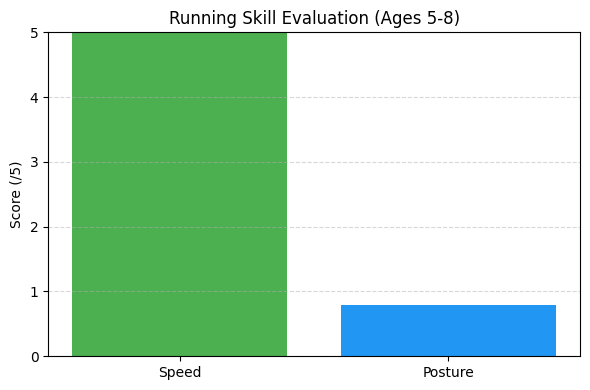

2.9

In [41]:
# --- Running Skill Evaluation (Ages 5-8) ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

pose_model = YOLO('yolov8n-pose.pt')

def evaluate_running_skill(video_path):
    cap = cv2.VideoCapture(video_path)
    previous_position = None
    total_distance = 0
    frame_count = 0
    good_posture_frames = 0
    posture_threshold = 10  # degrees for upright posture

    speeds = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = pose_model(frame)
        frame_count += 1

        for result in results:
            if result.keypoints is not None and result.keypoints.xy.shape[1] >= 17:
                keypoints = result.keypoints.xy.cpu().numpy()[0]
                ankle = keypoints[15]
                hip = keypoints[11]

                if previous_position is not None:
                    dist = np.linalg.norm(ankle - previous_position)
                    total_distance += dist
                    speeds.append(dist)
                previous_position = ankle

                # posture angle (hip to ankle line vs vertical)
                delta_x = abs(ankle[0] - hip[0])
                delta_y = abs(ankle[1] - hip[1])
                angle = np.degrees(np.arctan2(delta_x, delta_y))

                if angle < posture_threshold:
                    good_posture_frames += 1

    cap.release()

    # Compute scores
    avg_speed = np.mean(speeds)
    posture_ratio = good_posture_frames / frame_count if frame_count > 0 else 0

    # Score out of 5
    speed_score = min(5, avg_speed * 10)
    posture_score = min(5, posture_ratio * 5)
    total_score = round((speed_score + posture_score) / 2, 2)

    print(f"\n🏃‍♂️ Running Speed Score: {speed_score:.2f}/5")
    print(f"🧍‍♂️ Posture Score: {posture_score:.2f}/5")
    print(f"⭐ Final Running Skill Score: {total_score}/5")

    # Visualization
    labels = ['Speed', 'Posture']
    values = [speed_score, posture_score]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=['#4caf50', '#2196f3'])
    plt.ylim(0, 5)
    plt.title('Running Skill Evaluation (Ages 5-8)')
    plt.ylabel('Score (/5)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return total_score
evaluate_running_skill("/content/istockphoto-1426226925-640_adpp_is.mp4")

**2-Ball Feeling**

In [43]:
# --- Ball Feeling Skill Evaluation (Ages 5-8) ---
def evaluate_ball_feeling_skill(video_path):
    cap = cv2.VideoCapture(video_path)
    contact_count = 0
    frame_count = 0

    prev_contact = False
    contact_threshold = 50  # distance threshold (pixels)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        pose_results = pose_model(frame)
        ball_results = ball_model(frame)

        foot = None
        ball = None

        for result in pose_results:
            if result.keypoints is not None and result.keypoints.xy.shape[1] >= 17:
                keypoints = result.keypoints.xy.cpu().numpy()[0]
                foot = keypoints[16]  # right foot (ankle)

        for r in ball_results:
            for box in r.boxes:
                if int(box.cls[0]) == 32:  # COCO class ID for sports ball
                    ball = box.xywh[0][:2].cpu().numpy()

        # Check if both detected
        if foot is not None and ball is not None:
            dist = np.linalg.norm(foot - ball)
            if dist < contact_threshold:
                if not prev_contact:
                    contact_count += 1
                    prev_contact = True
            else:
                prev_contact = False

    cap.release()
    # Score calculation
    if contact_count >= 10:
        score = 5
    elif contact_count >= 7:
        score = 4
    elif contact_count >= 5:
        score = 3
    elif contact_count >= 3:
        score = 2
    elif contact_count >= 1:
        score = 1
    else:
        score = 0

    print(f"⚽ Total Ball Contacts Detected: {contact_count}")
    print(f"⭐ Ball Feeling Skill Score: {score}/5")

    # Visualization
    labels = ['Ball Touches']
    values = [score]

    plt.figure(figsize=(5, 4))
    plt.bar(labels, values, color='orange')
    plt.ylim(0, 5)
    plt.title('Ball Feeling Evaluation')
    plt.ylabel('Score (/5)')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    return score
evaluate_ball_feeling_skill("/content/9502550-sd_506_960_24fps.mp4")


0: 640x352 1 person, 287.2ms
Speed: 6.0ms preprocess, 287.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 289.7ms
Speed: 5.9ms preprocess, 289.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 271.9ms
Speed: 6.5ms preprocess, 271.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 265.3ms
Speed: 6.4ms preprocess, 265.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 274.6ms
Speed: 6.4ms preprocess, 274.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 258.9ms
Speed: 6.8ms preprocess, 258.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 248.8ms
Speed: 7.8ms preprocess, 248.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 sports ball, 244.7ms
Speed: 5.6ms p

**3-Focus & Listening Skill**

In [44]:


# --- Focus & Listening Skill Evaluation (Ages 5-8) ---
def evaluate_focus_listening_skill(video_path):
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

    cap = cv2.VideoCapture(video_path)
    total_frames = 0
    attentive_frames = 0
    distracted_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        total_frames += 1
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(frame_rgb)

        if results.detections:
            for detection in results.detections:
                # Get location data
                location = detection.location_data
                if location.relative_bounding_box.xmin < 0.4 or location.relative_bounding_box.xmin > 0.6:
                    distracted_frames += 1
                else:
                    attentive_frames += 1
        else:
            distracted_frames += 1

    cap.release()

    # Avoid divide by zero
    focus_ratio = attentive_frames / total_frames if total_frames > 0 else 0

    # Score logic
    if focus_ratio >= 0.8:
        score = 5
    elif focus_ratio >= 0.6:
        score = 4
    elif focus_ratio >= 0.4:
        score = 3
    elif focus_ratio >= 0.2:
        score = 2
    elif focus_ratio >= 0.05:
        score = 1
    else:
        score = 0

    print(f"📊 Attentive: {attentive_frames}, Distracted: {distracted_frames}")
    print(f"⭐ Focus & Listening Score: {score}/5")

    # Visualization
    plt.bar(['Focus'], [score], color='purple')
    plt.ylim(0, 5)
    plt.title('👂 Focus & Listening Skill Evaluation')
    plt.ylabel('Score (/5)')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    return score

**4-First Meeting Evaluation**

In [45]:
# --- First Meeting Evaluation (Ages 5-8) ---
def extract_audio(video_path, output_audio="temp_audio.wav"):
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(output_audio, verbose=False, logger=None)
    return output_audio

def analyze_facial_emotions(video_path):
    cap = cv2.VideoCapture(video_path)
    emotions = {"happy": 0, "neutral": 0, "fear": 0, "sad": 0}
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count % 25 == 0:
            try:
                result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
                dominant = result[0]['dominant_emotion']
                if dominant in emotions:
                    emotions[dominant] += 1
            except:
                continue

    cap.release()
    total = sum(emotions.values())
    comfort_score = round((emotions["happy"] + emotions["neutral"]) / total * 5) if total > 0 else 1
    return comfort_score, emotions

def analyze_voice(audio_path):
    [Fs, x] = audioBasicIO.read_audio_file(audio_path)
    x = audioBasicIO.stereo_to_mono(x)
    F, _ = ShortTermFeatures.feature_extraction(x, Fs, 0.050 * Fs, 0.025 * Fs)
    energy = np.mean(F[1])

    if energy > 0.05:
        score = 5
    elif energy > 0.035:
        score = 4
    elif energy > 0.025:
        score = 3
    elif energy > 0.015:
        score = 2
    else:
        score = 1
    return score, round(energy, 4)

def evaluate_first_meeting(video_path):
    print("🎥 Extracting audio...")
    audio_path = extract_audio(video_path)

    print("🙂 Analyzing facial emotions...")
    face_score, face_emotions = analyze_facial_emotions(video_path)

    print("🎙️ Analyzing voice confidence...")
    voice_score, energy = analyze_voice(audio_path)

    final_score = round((face_score + voice_score) / 2)

    print("\n📊 Detailed Report:")
    print(f"✅ Facial Comfort Score: {face_score}/5")
    print(f"✅ Voice Confidence Score: {voice_score}/5 (Energy={energy})")
    print(f"🎯 Final First Meeting Score: {final_score}/5")
    print("😊 Emotion Breakdown:", face_emotions)

    # Visualization
    labels = ['Facial Comfort', 'Voice Confidence']
    values = [face_score, voice_score]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=['#ffc107', '#00bcd4'])
    plt.ylim(0, 5)
    plt.title('First Meeting Evaluation')
    plt.ylabel('Score (/5)')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    return final_score


In [46]:
# --- Combined Kids Skills Evaluation ---
def evaluate_all_kids_skills(running_path, ball_path, focus_path, meeting_path):
    print("\n🧒 Evaluating All Core Skills for Kids (Ages 5-8)...")
    running_score = evaluate_running_skill(running_path)
    ball_score = evaluate_ball_feeling_skill(ball_path)
    focus_score = evaluate_focus_listening_skill(focus_path)
    meeting_score = evaluate_first_meeting(meeting_path)

    scores = {
        "Running": running_score,
        "Ball Feeling": ball_score,
        "Focus & Listening": focus_score,
        "First Meeting": meeting_score
    }

    total = round(sum(scores.values()), 2)
    avg_score = round(total / len(scores), 2)

    print("\n✅ Total Score:", total, "/ 20")
    print("🏅 Average Score:", avg_score, "/ 5")

    # Visualization
    plt.figure(figsize=(8, 5))
    bars = plt.bar(scores.keys(), scores.values(), color=['#4caf50', '#2196f3', '#9c27b0', '#ff9800'])
    plt.ylim(0, 5)
    plt.title(f"Final Evaluation Summary (Avg Score: {avg_score}/5)")
    plt.ylabel("Score (/5)")
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return scores, total, avg_score
